![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/rl_banner.png?raw=true)

# TD(N): Bias/Variance Tradeoff

You may have heared of the Bias/Variance tradeoff in ML, and I am happy to report that the same idea makes its way in Reinforcement Learning! Lets look at the two methods we have explored so far:

1) Monte Carlo Methods
2) TD-Learning

In both cases we are trying to estimate the discounted returns, but in **Monte Carlo**, we will perform a full trajectory and get real experience data, and in **TD-Learning** we boostrap our estimates so we can learn something at every step. But in the end, we are using these methods as an **ESTIMATOR**, and estimators have the Bias/Variance Tradeoff:

#### Monte Carlo

Monte Carlo involves getting real estimates from real experiences beacuse we have a full trajectory that we just captured. This means we have a very low bias as our esimates for future rewards are coming again from a real sequence of events. On the other hand, when going through a trajectory in a stochastic environment we can have very different outcomes even if we take the same actions. Therefore there is lots of variance!

#### TD Targets

TD Targets is exactly the opposite. In TD Learning we attempt to estimate our future rewards for the trajectory with just a single step and then bootstrapping. In a single step there isn't as much opportunity for randomness, therefore our variance is lower! On the other hand, our estimates for long trajectories are being estimated by a single step, so we are more likely to be wrong. Therefore we have a higher bias!

### TD(N) As a Compromise

So we clearly have a compromise here. We either are doing our estimates on a single step (TD-Learning or TD(0)), or we are doing estimates on an entire trajectory. What if we do a middle ground and do our estimates on shorter trajectories? This is exactly what TD(N) does, instead of doing just 1 step or all the steps, just do some middle amount of steps

#### Note: 

TD-Learning is a class of algorithms, or really just a way to solve something. We can apply it to our Values function $V(s)$ or to our Q-Values $Q(s,a)$. Its upto you for what you want to estimate. But because we did our $Q$ values in Q-Learning and SARSA, lets just stay consistent!

### Lets Implement It!

The implementation of this is pretty straight forward, and basically the same as our previous ones of Q-Learning, and Monte Carlo. We could have also done an On-Policy implementation like SARSA, instead of Off-Policy like Q-Learning, its completely up to you. As you can see, these are just all methods that you can put together however you want! The key changes are:



In [1]:
import numpy as np
from tqdm.notebook import tqdm
import gymnasium as gym

def epsilon_greedy(Q, state, epsilon, env):

    ### Either sample a random action (explore) or 
    ### Use best action according to Q Table 
    
    if np.random.rand() < epsilon:
        return env.action_space.sample() 
    else:
        return np.argmax(Q[state])
        
def n_step_q_learning(env, 
                      n=3, 
                      num_episodes=25000, 
                      alpha=0.01, 
                      gamma=0.99, 
                      epsilon=0.1):

    Q = np.zeros((env.observation_space.n, env.action_space.n))
    episode_rewards = []
    
    for episode in tqdm(range(num_episodes)):
        
        state, _ = env.reset()

        ### Select an Action to Start Out ###
        action = epsilon_greedy(Q, state, epsilon, env)
            
        ### Storage for States, Actions and Rewards ###
        states = []
        actions = []
        rewards = []
        total_reward = 0

        done = False
        while not done:

            ### Take an Action ###
            next_state, reward, terminal, truncated, _ = env.step(action)
            done = terminal or truncated

            ### Sample a New Action ###
            next_action = epsilon_greedy(Q, next_state, epsilon, env)

            ### Store Experience ###
            states.append(state)
            actions.append(action)
            rewards.append(reward)

            ### Accumulate Reward for Logging ###
            total_reward += reward

            ### If we have enough samples compute our returns ###
            if len(rewards) >= n:

                ### Add Together All Rewards (discounted by Gamma) ###
                ### so we have our estimate of our estimated returns ###
                ### from the first state that we started from! ###
                ### r_0 + gamma*r_1 + gamma**2 * r_2 + ... ###
                G = sum([gamma**i * rewards[i] for i in range(n)])

                ### If the Game is Not Over, there are future rewards that ###
                ### we can boostrap from our current estimate of Q (just like Q Learning) ###
                if not done:
                    G += gamma**n * np.max(Q[next_state])

                ### Update our Q Values from our Starting State ###
                ### As we used n steps as a better estimate of the future! ###
                ### G is our TD Target now, and we want to move Q towards this ###
                Q[states[0], actions[0]] += alpha * (G - Q[states[0], actions[0]])

                ### We have completed Our estimate, remove the first experience ###
                states.pop(0)
                actions.pop(0)
                rewards.pop(0)

      
            ### Set our next state and action ###
            state, action = next_state, next_action

        ### Store the Total Rewards ###
        episode_rewards.append(total_reward)
    
        ### If the game ended, we still have a few samples left in our buffer ###
        ### We can go ahead and add those computations in as well! ###
        ### Everything else is the same, it just wont be an n-step estimate anymore ###
        ### beacuse we dont have n steps left (as we terminated) ###
        while rewards:
            G = sum([gamma**i * rewards[i] for i in range(len(rewards))])
            Q[states[0], actions[0]] += alpha * (G - Q[states[0], actions[0]])
            states.pop(0)
            actions.pop(0)
            rewards.pop(0)

    return Q, episode_rewards
    

The Frozen-Lake environment is pretty sparse about its rewards, so we dont see a ton of gain here with this method. Lets try a different game that provides more reward information.

### Cliff Walking

<img src="https://gymnasium.farama.org/_images/cliff_walking.gif" alt="drawing" width="800"/>

Rules of the game are very simple! There are 48 spots to be in, and we have 4 actions we can take (just like before). Our goal is to get fromm the left side to the right side without falling off of the cliff. You can see more game details [here](https://gymnasium.farama.org/environments/toy_text/cliff_walking/)! If you fall off the cliff, you get a reward of -100, so as long as our rewards is more than -100 we have won that game!



In [2]:
def test_policy(policy, env, num_episodes=100):

    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0

        while not done:
            action = policy[state]
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward

        total_rewards.append(ep_reward)

    success_rate = np.mean([1 if r > -100 else 0 for r in total_rewards])
    print(f"Success Rate: {success_rate * 100:.2f}%")
    return success_rate
    
### Train Model ###
Qs = []
rewards = []
ns = [1,3,5,7,9,11]
env = gym.make('CliffWalking-v0')

for n in ns:
    print(f"Training {n}-Step")
    Q, reward = n_step_q_learning(env, n)
    rewards.append(reward)
    policy = np.argmax(Q, axis=-1)
    test_policy(policy, env)
    

Training 1-Step


  0%|          | 0/25000 [00:00<?, ?it/s]

Success Rate: 100.00%
Training 3-Step


  0%|          | 0/25000 [00:00<?, ?it/s]

Success Rate: 100.00%
Training 5-Step


  0%|          | 0/25000 [00:00<?, ?it/s]

Success Rate: 100.00%
Training 7-Step


  0%|          | 0/25000 [00:00<?, ?it/s]

Success Rate: 100.00%
Training 9-Step


  0%|          | 0/25000 [00:00<?, ?it/s]

Success Rate: 100.00%
Training 11-Step


  0%|          | 0/25000 [00:00<?, ?it/s]

Success Rate: 100.00%


### Let Look At Our Rewards

I will smooth the rewards lists out a bit so we have a moving average of the rewards instead!

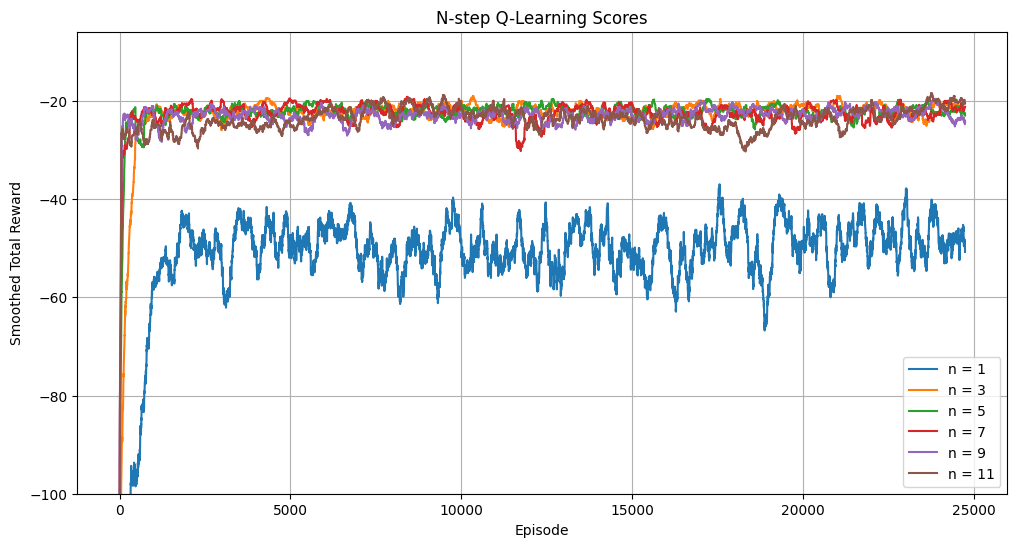

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for n, reward in zip(ns, rewards):
    smoothed = np.convolve(reward, np.ones(250)/250, mode='valid')
    plt.plot(smoothed, label=f"n = {n}")
plt.xlabel("Episode")
plt.ylabel("Smoothed Total Reward")
plt.ylim(-100)
plt.title("N-step Q-Learning Scores")
plt.legend()
plt.grid()
plt.show()

As we can see, literally anything is better than just a single step (which was the Q-Learning method we were doing earlier!). TD(N) did a fixed-n boostrapping of the return esimates. We could also do a weighted average of all n-step returns! This will be our TD($\lambda$) thats up next!